In [58]:
import os
import numpy as np
import random
import csv
from tqdm import tqdm
import matplotlib.pyplot as plt
import itertools
#from dataset import dataset
#from additional_functions import process_all
#from additional_functions import save_arrays_to_csv
#from additional_functions import load_arrays_from_csv
from additional_functions import make_plots_2

In [59]:
# All files were developed collaboratively
# Currently the save function for the validation set does not work, this functionality can be added later
# as the processing should be working correctly.
class dataset:
    '''
    The dataset class handles initial data loading along with all pre-processing tasks
    '''
    def __init__(self, data_path: str, processed_flag: str):
        '''
        The constructor initializes all of the self variables, and loads the data from the original .data file.
        '''
         # Instantiate self variables
        self.intake_data = []
        self.tune_set = []
        self.validate_set = []
        self.ninety_data = []

        # Data is being read in from original .DATA file
        if (processed_flag == False):
            # Separating the .data file into lines, and shuffling the lines
            with open(data_path, 'r') as file:
                lines = file.readlines()
            # Deliminate strings into lists
            for i in range(len(lines)):
                lines[i] = lines[i].strip()
                lines[i] = lines[i].split(',')  
            # Make the list into a numpy array
            self.intake_data = np.array(lines)

    def normalize(self, prediction_type: str):
        '''
        performs mim-max normalization on the last column of the intake data (example value). This will only be used for regression data.
        '''
        # Separate features and labels
        features = self.intake_data[:, :-1]  # All columns except the last one (features)
        labels = self.intake_data[:, -1]     # Last column (labels)

        # Apply min-max normalization to features
        features_min = features.min(axis=0)
        features_max = features.max(axis=0)
        
        denominator = (features_max - features_min)
        denominator[denominator == 0]+= 1e10
        normalized_features = (features - features_min) / denominator

        if prediction_type == "regression":
            normalized_labels = (labels - labels.min()) / (labels.max() - labels.min())
        else:
            # Create a mapping from the original labels to new labels starting from 0
            unique_labels = np.unique(labels)
            label_mapping = {old_label: new_label for new_label, old_label in enumerate(unique_labels)}

            # Map the labels to new values starting from 0
            new_labels = np.array([label_mapping[label] for label in labels])

            normalized_labels = new_labels

        # Combine normalized features with labels
        # if this does not work make self.intake_data[:,:-1] and self.intake_data[:,-1] equal the normalized labels and features matrices
        normalized_data = np.hstack((normalized_features, normalized_labels.reshape(-1, 1)))
        self.intake_data = normalized_data

        '''
        if prediction_type == "classification":
            # normalize features, not labels
            values = self.intake_data[:,-1].astype(float)
            normalized_values = (values - values.min()) / (values.max() - values.min())
            self.intake_data[:, -1] = normalized_values
        else:
            # normalize entire matrix
        values = self.intake_data[:,-1].astype(float)
        normalized_values = (values - values.min()) / (values.max() - values.min())
        self.intake_data[:, -1] = normalized_values
        '''
    def oh_encode(self):
        '''
        This method goes through each item in the data array, and if the item is not a number, it is replaced with a number (continuization).
        If there are no non-numbers in the dataset, all the numbers are converted to floats.
        '''
        string_to_int = {}
        next_int = 0
        # This function continuizes a single element so it can be vectorized
        def convert_to_num(value):
            nonlocal next_int
            try:
                # Try to convert to float
                return float(value)
            except ValueError:
                # If conversion fails, map the string a number
                if value not in string_to_int:
                    string_to_int[value] = next_int
                    next_int += 1
                return string_to_int[value]

        # Apply convert_to_num to each element in the array
        vectorization = np.vectorize(convert_to_num, otypes=[float])
        self.intake_data = vectorization(self.intake_data)
    def impute(self):
        '''
        Replaces question marks in a dataset with a random value between 1 and 10.
        '''
        for ex_idx in range(len(self.intake_data)):
            for att_idx in range(len(self.intake_data[ex_idx])):
                # if this statement is entered that means there is a missing piece of attribute data, so imputation needs to occur at this location
                if (self.intake_data[ex_idx][att_idx] == '?'):
                    # This will be the imputation method using range 1-10
                        self.intake_data[ex_idx][att_idx] = str(random.randint(1,10))
    def shuffle(self):
        '''
        This method will shuffle the self.intake_data by examples.
        '''
        np.random.shuffle(self.intake_data)
    def sort(self, prediction_type_flag):
        '''
        Sorts the data by its class/target value. We can assume all labels are the last indice of an example.
        The prediction_type_flag essentially tells us if the last indice can be converted to a float or not. Regression datasets are sorted by value
        '''
        if prediction_type_flag == "regression":
            #print('REGRESSION')
            sorted_data = self.intake_data[self.intake_data[:, -1].astype(np.float32).argsort()]
        else:
            #print("CLASSIFICATION")
            sorted_data = self.intake_data[self.intake_data[:, -1].argsort()]
        self.intake_data = sorted_data
    def split(self):
        '''
        Puts the first 10% of the data into its own array (self.tune_set), then the remaining data (self.validate_set) into its own array.
        We should end up with two arrays, both are sorted and stratified. The validation will still need to be separated into partitions.
        '''
        tune_data = []
        for i, example in enumerate(self.intake_data):
            if(i % 10) == 0:
                tune_data.append(example)
            else:
                self.ninety_data.append(example)
        self.tune_set = np.array(tune_data)
        self.ninety_data = np.array(self.ninety_data)
    def fold(self):
        '''
        This method folds self.validate_set into stratified partitions
        '''
        # shape should be (10, # of examples, # of attributes)
        shape = (10, (len(self.ninety_data) // 10) + 1, len(self.ninety_data[0]))
        self.validate_set = np.full(shape, np.nan)
        fold_counts = np.zeros(10)

        # splits data into folds
        for i, example in enumerate(self.ninety_data):
            fold_index = i % 10
            example_position = fold_counts[fold_index]  #This finds the next null example
            self.validate_set[fold_index, int(example_position)] = example
            fold_counts[fold_index] += 1
    def shuffle_splits(self):
        '''
        Shuffles the tune set and validate set after they are complete and stratified
        '''
        np.random.shuffle(self.tune_set)
        for partition_idx, partition in enumerate(self.validate_set):
            np.random.shuffle(partition)
    def remove_attribute(self, indice=0):
        '''
        Takes in an attribute indice, and removes that entire indice from the dataset. This can be used to remove ID numbers
        '''
        self.intake_data = np.delete(self.intake_data, indice, 1)    
    def save(self, filename: str):
        """
        saves the tune set and validation set to a csv file for inspection purposes.
        """
        #get/create the path to the folder that the file should be saved to
        folder_path = os.path.expanduser(f"~/CSCI_447/Project_3/Datasets/processed_data")  
        os.makedirs(folder_path, exist_ok=True)
        tune_file_path = os.path.join(folder_path, (filename+'_tune_set.csv'))
        validate_file_path = os.path.join(folder_path, (filename+'_validate_set.csv'))

        # save the tune set
        shape_info = None
        with open(tune_file_path, mode='w', newline='') as file:
            writer = csv.writer(file)
            if shape_info:
                writer.writerow(["shape"] + list(shape_info))
            writer.writerows(self.tune_set)

        # save the validation set
        reshaped_array = np.array([[';'.join(str(row)) for row in batch] for batch in self.validate_set])
        shape_info = self.validate_set.shape
        with open(validate_file_path, mode='w', newline='') as file:
            writer = csv.writer(file)
            if shape_info:
                writer.writerow(["shape"] + list(shape_info))
            writer.writerows(reshaped_array)
    def extract(self, file_path: str):
        """
        Loads data from a CSV file and converts it back to a numpy array in the original format.
        """
        tune_file_path = file_path+'_tune_set.csv'
        validate_file_path = file_path+'_validate_set.csv'

        # extract the tune set
        with open(tune_file_path, mode='r') as file:
            reader = csv.reader(file)
            rows = list(reader)
        self.tune_set = np.array(rows, dtype=str)

        # extract the validate set
        with open(validate_file_path, mode='r') as file:
            reader = csv.reader(file)
            rows = list(reader)
        shape_info = tuple(map(int, rows[0][1:]))
        data = rows[1:]
        reconstructed_data = [[cell.split(';') for cell in row] for row in data]
        self.validate_set = np.array(reconstructed_data, dtype=str).reshape(shape_info)

In [60]:
def process_all(user: str, shuffle_split: bool):
    # instantiates the datasets
    abalone_data = dataset('/home/'+user+'/CSCI_447/Project_2/Datasets/abalone.data', False)
    cancer_data = dataset('/home/'+user+'/CSCI_447/Project_2/Datasets/breast-cancer-wisconsin.data', False)
    fire_data = dataset('/home/'+user+'/CSCI_447/Project_2/Datasets/forestfires.data', False)
    glass_data = dataset('/home/'+user+'/CSCI_447/Project_2/Datasets/glass.data', False)
    machine_data = dataset('/home/'+user+'/CSCI_447/Project_2/Datasets/machine.data', False)
    soybean_data = dataset('/home/'+user+'/CSCI_447/Project_2/Datasets/soybean-small.data', False)

    # abalone processing
    abalone_data.oh_encode()
    abalone_data.normalize("regression")
    abalone_data.shuffle()
    abalone_data.sort('regression')
    abalone_data.split()
    abalone_data.fold()

    # cancer processing
    cancer_data.oh_encode()
    cancer_data.normalize("classification")
    cancer_data.remove_attribute()
    cancer_data.impute()
    cancer_data.shuffle()
    cancer_data.sort('classification')
    cancer_data.split()
    cancer_data.fold()

    # fire processing
    fire_data.oh_encode()
    fire_data.normalize("regression")
    fire_data.shuffle()
    fire_data.sort('regression')
    fire_data.split()
    fire_data.fold()

    # glass processing
    glass_data.oh_encode()
    glass_data.remove_attribute()
    glass_data.normalize("classification")
    glass_data.shuffle()
    glass_data.sort('classification')
    glass_data.split()
    glass_data.fold()

    # machine processing
    machine_data.oh_encode()
    machine_data.normalize("regression")
    machine_data.shuffle()
    machine_data.sort('regression')
    machine_data.split()
    machine_data.fold()

    # soybean processing
    soybean_data.oh_encode()
    soybean_data.normalize("classification")
    #soybean_data.shuffle()
    soybean_data.sort('classification')
    soybean_data.split()
    soybean_data.fold()

    # Final shuffle of the data
    if (shuffle_split == True) :
        abalone_data.shuffle_splits()
        cancer_data.shuffle_splits()
        fire_data.shuffle_splits()
        glass_data.shuffle_splits()
        machine_data.shuffle_splits()
        soybean_data.shuffle_splits()

    # save the datasets
    abalone_data.save('abalone')
    cancer_data.save('cancer')
    fire_data.save('fire')
    glass_data.save('glass')
    machine_data.save('machine')
    soybean_data.save('soybean')

    return abalone_data, cancer_data, fire_data, glass_data, machine_data, soybean_data

In [61]:
class neural_net:
    def __init__(self, data: dataset, prediction_type_flag: str, hidden_layer_count=0, network_shape=[], hidden_node_count=1, epochs=100, momentum=.9, learning_rate=.01, batch_size=10, suppress_plots=True):
        self.suppress_plots = suppress_plots
        self.epochs = epochs
        self.momentum = momentum
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.hidden_layer_count = hidden_layer_count
        if hidden_layer_count == 0:
            hidden_node_count = 0
        else:
            hidden_node_count = [hidden_node_count] * hidden_layer_count
        self.tune_set = data.tune_set
        self.validate_set = data.validate_set
        self.prediction_type = prediction_type_flag

        if self.prediction_type == "classification":
            self.class_count = len(np.unique(self.tune_set[:,-1]))
        else:
            self.class_count = 0

        input_size = self.tune_set.shape[1] - 1
        self.input_size = input_size
        if network_shape == []:
            self.network_shape = [input_size] + (hidden_node_count if hidden_node_count else []) + ([self.class_count] if (self.prediction_type == "classification") else [1])
        else:
            self.network_shape = network_shape
        self.biases = []
        self.weights = []
        self.bias_velocity = []
        self.weight_velocity = []

    def init_weights_biases_momentum(self):
        '''
        Initializes weights based on the network shape list
        '''
        self.biases = [np.random.randn(next_size, 1) for next_size in self.network_shape[1:]]
        self.weights = [np.random.randn(next_size, cur_size) for cur_size, next_size in zip(self.network_shape[:-1], self.network_shape[1:])]
        self.bias_velocity = [np.zeros(bias.shape) for bias in self.biases]
        self.weight_velocity = [np.zeros(weight.shape) for weight in self.weights]
        #print(self.biases)


    def for_prop(self, input: np):
        '''
        Feeds forward a single example through the network
        '''
        output = input
        for bias, weight in zip(self.biases[:-1], self.weights[:-1]):
            output = self.sigmoid(np.dot(weight, output) + bias)
        # Not sure right now if output will be correct for regression, but life goes on.
        # The following lines choose the output activation function based on prediction type
        bias, weight = self.biases[-1], self.weights[-1]
        # MIGHT NEED TO RESHAPE THE DOT PRODUCT ON THE LINE BELOW
        output = (np.dot(weight, output) + bias)
        if self.prediction_type == "classification":
            output = self.softmax(output)
        return output
    
    def get_training_data(self, i: int):
        '''
        method needs to take the set of fold i-(i-1) and and compile those into its own array.
        Then format the data as follows: each example = (attributes, label)
        i is used to indicate which training set you want returned
        '''
        desired_data = np.concatenate([self.validate_set[j] for j in range(10) if j != i])
        training_data = [(example[:-1], example[-1]) for example in desired_data]
        return training_data
    
    def get_testing_data(self, i: int):
        '''
        method needs to take the set of fold i-(i-1) and and compile those into its own array.
        Then format the data as follows: each example = (attributes, label)
        i is used to indicate which training set you want returned
        '''
        desired_data = self.validate_set[i]
        testing_data = [(example[:-1], example[-1]) for example in desired_data]
        return testing_data
    
    def get_tuning_data(self):
        '''
        method needs to take the set of fold i-(i-1) and and compile those into its own array.
        Then format the data as follows: each example = (attributes, label)
        i is used to indicate which training set you want returned
        '''
        desired_data = self.tune_set
        tuning_data = [(example[:-1], example[-1]) for example in desired_data]
        return tuning_data

    def grad_desc(self, training_data, epochs, momentum, learning_rate, batch_size):
        '''
        Takes in a traing set from get_training_data. The format is a list of tuples, where each tuple
        represents an example. Within each tuple the first value is the feature vector and the second
        value is the label.
        '''
        example_count = len(training_data)
        for epoch in range(epochs):
            random.shuffle(training_data)
            mini_batches = [training_data[k:k+batch_size] for k in range(0, example_count, batch_size)]
            for mini_batch in mini_batches:
                self.update_weights(mini_batch, momentum, learning_rate)

    def update_weights(self, mini_batch, momentum, learning_rate):
        '''
        NEEDS COMMENTING/PARSING
        '''
        bias_gradient = [np.zeros(bias.shape) for bias in self.biases]
        weight_gradient = [np.zeros(weight.shape) for weight in self.weights]

        # Compute gradients for the mini-batch
        for feature, label in mini_batch:
            #print(type(label))
            if not np.isnan(label):
                delta_bias_gradient, delta_weight_gradient = self.epoch(feature, label)
                bias_gradient = [gradient + delta for gradient, delta in zip(bias_gradient, delta_bias_gradient)]
                weight_gradient = [gradient + delta for gradient, delta in zip(weight_gradient, delta_weight_gradient)]
        
        # Update velocities and apply updates with momentum
        self.bias_velocity = [momentum * velocity - (learning_rate / len(mini_batch)) * gradient for velocity, gradient in zip(self.bias_velocity, bias_gradient)]
        self.weight_velocity = [momentum * velocity - (learning_rate / len(mini_batch)) * gradient for velocity, gradient in zip(self.weight_velocity, weight_gradient)]

        # Update weights and biases
        self.biases = [bias + velocity for bias, velocity in zip(self.biases, self.bias_velocity)]
        self.weights = [bias + velocity for bias, velocity in zip(self.weights, self.weight_velocity)]

    def epoch(self, feature, label):
        '''
        NEEDS COMMENTING/PARSING
        '''
        #print(f"\n\nLABEL: {label}\n\n")
        bias_gradient = [np.zeros(bias.shape) for bias in self.biases]
        weight_gradient = [np.zeros(weight.shape) for weight in self.weights]
        # feedforward
        activation = feature
        activations = [feature] # list to store all the activations, layer by layer
        weighted_inputs = [] # list to store all the z vectors, layer by layer
        #print(f"Biases: {self.biases[-1]}")
        #print(f"Weights: {self.weights[-1]}")
        for bias, weight in zip(self.biases[:-1], self.weights[:-1]):
            #print(f"Activation:\n{activation.shape}\n\nWeight:\n{weight.shape}\n\nBias:\n{bias.shape}\n\n\n")
            weighted_input = np.dot(weight, activation.reshape(-1,1)) + bias
            #print(f"Weighted Input:\n{weighted_input.shape}")
            activation = self.sigmoid(weighted_input)
            weighted_inputs.append(weighted_input)
            activations.append(activation)
        # The output layer uses different activation functions
        bias, weight = self.biases[-1], self.weights[-1]
        #print(f"Activation:\n{activation}\n\nWeight:\n{weight.shape}\n\nBias:\n{bias.shape}\n\n\n")
        #print(f"Dot Product Shape:\n{np.dot(weight, activation).reshape(-1,1)}\n\n")
        weighted_input = np.dot(weight, activation.reshape(-1,1)) + bias
        #weighted_input = np.dot(weight, activation)
        #print(f"Weighted Input (Should be two scalars):\n{(weighted_input.shape)}")
        activation = weighted_input
        if self.prediction_type == "classification":
            activation = self.softmax(weighted_input)
        weighted_inputs.append(weighted_input)
        activations.append(activation)
        #print(f"Activations:\n{activations}\n\nWeighted Inputs:\n{weighted_inputs}")
    


        # backward pass
        # NEED TO ONE-HOT ENCODE THE LABELS FOR CLASSIFICATION SETS TO MAKE THE DELTA LINE WORK
        # PROLLY WON'T NEED LOSS PRIME METHOD
        if self.prediction_type == "classification":
            one_hot_label = [0] * self.class_count
            one_hot_label[int(label)] = 1
            one_hot_label = np.array(one_hot_label).reshape(-1, 1)
        else:
            one_hot_label = label
        #print(f"Activations[-1]:\n{activations[-1]}\nOne-Hot Label:\n{one_hot_label}")
        delta = (activations[-1] - one_hot_label)# * self.softmax(weighted_inputs[-1])
        bias_gradient[-1] = delta
        #print(f"Delta:\n{delta}\n\nActivations:\n{activations[-2].reshape(1,-1)}\n\n")
        weight_gradient[-1] = np.dot(delta, activations[-2].reshape(1,-1))# # CHECK THIS LINE FOR COMPREHENSION

        for layer_idx in range(2, len(self.network_shape)):
            weighted_input = weighted_inputs[-layer_idx]
            activation_prime = self.sigmoid_prime(weighted_input)
            delta = np.dot(self.weights[-layer_idx+1].transpose(), delta) * activation_prime
            # add logic to convert scalar if delta is 1x1
            if delta.shape == (1,1):
                bias_gradient[-layer_idx] = delta.reshape(-1)
                weight_gradient[-layer_idx] = (delta.reshape(-1) * activations[-layer_idx-1].transpose())
            else:
                bias_gradient[-layer_idx] = delta
                weight_gradient[-layer_idx] = np.dot(delta, activations[-layer_idx-1].reshape(1,-1))
        #print("GOT TO THE END")
        return (bias_gradient, weight_gradient)

    def tune(self):
        # CONSIDER REMOVING THE TQDM ON EPOCHS
        hidden_node_vals = [1, 3, 5, 7, 9]
        epoch_vals = [10, 50, 100, 200, 500]
        momentum_vals = [0.5, 0.7, 0.9, 0.95, 0.99]
        learning_rate_vals = [0.0001, 0.001, 0.01, 0.1, 1.0]
        batch_size_vals = [16, 32, 64, 128, 256]

        hidden_node_scores = []
        epoch_scores = []
        momentum_scores = []
        learning_rate_scores = []
        batch_size_scores = []

        # Hidden node Count Tuning
        if (self.hidden_layer_count > 0):
            hidden_node_combinations = list(itertools.product(hidden_node_vals, repeat=self.hidden_layer_count))
            for combination in tqdm(hidden_node_combinations, desc="Tuning Hidden Node Count", leave=False):
                self.network_shape = [self.input_size] + (list(combination)) + ([self.class_count] if (self.prediction_type == "classification") else [1])
                hidden_node_score = self.train_test(tuning_flag=True, epochs=self.epochs, momentum=self.momentum, learning_rate=self.learning_rate, batch_size=self.batch_size)
                hidden_node_scores.append(np.mean(hidden_node_score))
            hidden_node_scores = np.array(hidden_node_scores)
            if self.prediction_type == "classification":
                self.network_shape = [self.input_size] + (list(hidden_node_combinations[np.argmax(hidden_node_scores)])) + ([self.class_count] if (self.prediction_type == "classification") else [1])
            else:
                self.network_shape = [self.input_size] + (list(hidden_node_combinations[np.argmin(hidden_node_scores)])) + ([self.class_count] if (self.prediction_type == "classification") else [1])          
            print(f"Tuned Network Shape: {self.network_shape}")

        # Epoch tuning
        for epochs in tqdm(epoch_vals, desc="Tuning Epochs", leave=False):
            epoch_score = self.train_test(tuning_flag=True, epochs=epochs, momentum=self.momentum, learning_rate=self.learning_rate, batch_size=self.batch_size)
            epoch_scores.append(np.mean(epoch_score))
        epoch_scores = np.array(epoch_scores)
        if self.prediction_type == "classification":
            self.epochs = epoch_vals[np.argmax(epoch_scores)]
        else:
            self.epochs = epoch_vals[np.argmin(epoch_scores)]
        print(f"Tuned Epoch Value: {self.epochs}")

        # Momentum Tuning
        for momentum in tqdm(momentum_vals, desc="Tuning Momentum", leave=False):
            momentum_score = self.train_test(tuning_flag=True, epochs=self.epochs, momentum=momentum, learning_rate=self.learning_rate, batch_size=self.batch_size)
            momentum_scores.append(np.mean(momentum_score))
        momentum_scores = np.array(momentum_scores)
        if self.prediction_type == "classification":
            self.momentum = momentum_vals[np.argmax(momentum_scores)]
        else:
            self.momentum = momentum_vals[np.argmin(momentum_scores)]
        print(f"Tuned Momentum Value: {self.momentum}")

        # Learning rate tuning
        for learning_rate in tqdm(learning_rate_vals, desc="Tuning Learning Rate", leave=False):
            learning_rate_score = self.train_test(tuning_flag=True, epochs=self.epochs, momentum=self.momentum, learning_rate=learning_rate, batch_size=self.batch_size)
            learning_rate_scores.append(np.mean(learning_rate_score))
        learning_rate_scores = np.array(learning_rate_scores)
        if self.prediction_type == "classification":
            self.learning_rate = learning_rate_vals[np.argmax(learning_rate_scores)]
        else:
            self.learning_rate = learning_rate_vals[np.argmin(learning_rate_scores)]
        print(f"Tuned Learning Rate: {self.learning_rate}")

        # Batch size tuning
        for batch_size in tqdm(batch_size_vals, desc="Tuning Batch Size", leave=False):
            batch_size_score = self.train_test(tuning_flag=True, epochs=self.epochs, momentum=self.momentum, learning_rate=self.learning_rate, batch_size=batch_size)
            batch_size_scores.append(np.mean(batch_size_score))
        batch_size_scores = np.array(batch_size_scores)
        if self.prediction_type == "classification":
            self.batch_size = batch_size_vals[np.argmax(batch_size_scores)]
        else:
            self.batch_size = batch_size_vals[np.argmin(batch_size_scores)]
        print(f"Tuned Batch Size: {self.batch_size}")

        return [self.network_shape, self.epochs, self.momentum, self.learning_rate, self.batch_size]
    
    def train_test(self, tuning_flag: bool, epochs=100, momentum=.9, learning_rate=.01, batch_size=10):
        scores = []
        if tuning_flag:
            for i in range(10):
                self.init_weights_biases_momentum()
                self.grad_desc(self.get_training_data(i), epochs, momentum, learning_rate, batch_size)
                score = self.loss(self.get_tuning_data())
                scores.append(score)
        else:
            for i in tqdm(range(10), desc="Evaluating Test Data", leave=False):
                self.init_weights_biases_momentum()
                self.grad_desc(self.get_training_data(i), self.epochs, self.momentum, self.learning_rate, self.batch_size)
                score = self.loss(self.get_testing_data(0))
                scores.append(score)
        return np.array(scores)
    
    def loss(self, test_data):
        if self.prediction_type == "classification":
            results = [(np.argmax(self.for_prop(example)), label) for (example, label) in test_data if not np.isnan(label)]
            correct_results = sum(int(example == label) for (example, label) in results)
            total_examples = len(results)
            return correct_results / total_examples
        else:
            results = [(self.for_prop(x), y) for (x, y) in test_data if not np.isnan(y)]
            # Ensure predictions and labels are both 1D arrays of the same length
            predictions = np.array([prediction.flatten()[0] if prediction.size == 1 else np.argmax(prediction) for (prediction, label) in results], dtype=float)
            labels = np.array([label for (prediction, label) in results], dtype=float)

            # Calculate MSE
            mse = np.mean((predictions - labels) ** 2)
            return mse
            

            '''
            results = [(self.for_prop(x), y) for (x, y) in test_data if not np.isnan(y)]
            predictions = np.array([prediction.flatten() for (prediction, label) in results], dtype=float).reshape(-1)
            labels = np.array([label for (prediction, label) in results], dtype=float).reshape(-1)
            mse = np.mean((predictions - labels) ** 2)
            return mse
            '''
        
    '''
    def evaluate(self, test_data):
        """Return the accuracy of the network on the test data, excluding any NaN labels."""
        test_results = [(np.argmax(self.feedforward(x)), y) for (x, y) in test_data if not np.isnan(y) and len(x) == 2]
        correct_predictions = sum(int(x == y) for (x, y) in test_results)
        total_examples = len(test_results)
        return correct_predictions / total_examples if total_examples > 0 else 0
    '''

    '''
    def loss_prime(self):
        return
    '''
    def sigmoid(self, input: np):
        return 1.0/(1.0+np.exp(-input))
    def sigmoid_prime(self, input: np):
        return self.sigmoid(input)*(1-self.sigmoid(input))
    def softmax(self, input):
        exp = np.exp(input - np.max(input))
        return exp / np.sum(exp)
    '''
    # Since loss output is in a slightly different format for neural nets, we might need an final loss method to output final performance
    def final_loss(self):
        return
    '''
    # THIS PROLLY NEEDS EDITING
    def plot_loss(self, metrics: list, parameter: str, increment):
        '''
        This function plots the loss performance for each epoch. This allows us to visualize at how many epochs
        performance drops off.
        '''
        # Extract # of epochs and loss metrics
        metrics = np.array(metrics)
        epochs = np.arange(1, metrics.shape[0] + 1) * increment
        loss1 = metrics[:, 0]
        loss2 = metrics[:, 1]

        # Create loss plot
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, loss1, label='Loss Metric 1', marker='o')
        plt.plot(epochs, loss2, label='Loss Metric 2', marker='o')
        plt.xlabel(f'{parameter} Value')
        plt.ylabel('Loss')
        plt.title(f'Loss Metrics vs. {parameter} value')
        plt.legend()
        plt.grid(True)
        plt.show()
        plt.close()
    

# Neural Network Instantiation

In [62]:
abalone_data, cancer_data, fire_data, glass_data, machine_data, soybean_data = process_all('carlthedog3', True)

In [67]:
# Classification Sets
cancer_net_0 = neural_net(cancer_data, "classification", hidden_layer_count=0, epochs=10,momentum=.5,learning_rate=.01,batch_size=16)
cancer_net_1 = neural_net(cancer_data, "classification", hidden_layer_count=1, network_shape=[9,1,2],epochs=50,momentum=.7,learning_rate=.1,batch_size=16)
cancer_net_2 = neural_net(cancer_data, "classification", hidden_layer_count=2, network_shape=[9,1,5,2],epochs=50,momentum=.9,learning_rate=.01,batch_size=16)

glass_net_0 = neural_net(glass_data, "classification", hidden_layer_count=0, epochs=100,momentum=.5,learning_rate=.001,batch_size=16)
glass_net_1 = neural_net(glass_data, "classification", hidden_layer_count=1, network_shape=[9,1,6],epochs=500,momentum=.95,learning_rate=.01,batch_size=32)
glass_net_2 = neural_net(glass_data, "classification", hidden_layer_count=2, network_shape=[9,1,9,6],epochs=500,momentum=.95,learning_rate=.01,batch_size=32)

soybean_net_0 = neural_net(soybean_data, "classification", hidden_layer_count=0)
soybean_net_1 = neural_net(soybean_data, "classification", hidden_layer_count=1)
soybean_net_2 = neural_net(soybean_data, "classification", hidden_layer_count=2)


# Regression Sets
abalone_net_0 = neural_net(abalone_data, "regression", hidden_layer_count=0)
abalone_net_1 = neural_net(abalone_data, "regression", hidden_layer_count=1)
abalone_net_2 = neural_net(abalone_data, "regression", hidden_layer_count=2)

fire_net_0 = neural_net(fire_data, "regression", hidden_layer_count=0, epochs=200,momentum=.9,learning_rate=.01,batch_size=16)
fire_net_1 = neural_net(fire_data, "regression", hidden_layer_count=1)
fire_net_2 = neural_net(fire_data, "regression", hidden_layer_count=2)

machine_net_0 = neural_net(machine_data, "regression", hidden_layer_count=0)
machine_net_1 = neural_net(machine_data, "regression", hidden_layer_count=1)
machine_net_2 = neural_net(machine_data, "regression", hidden_layer_count=2)

# Abalone Tuning + Final Scores

In [5]:
abalone_net_0_parameters = abalone_net_0.tune()
abalone_0_score = abalone_net_0.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(abalone_0_score)}")

Tuned Epoch Value: 200


Tuned Momentum Value: 0.9


Tuned Learning Rate: 0.01


Tuned Batch Size: 32


Average Performance: 0.007549628473888485


In [6]:
abalone_net_1_parameters = abalone_net_1.tune()
abalone_1_score = abalone_net_1.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(abalone_1_score)}")

Tuned Network Shape: [8, 1, 1]


Tuned Epoch Value: 500


Tuned Momentum Value: 0.95


Tuned Learning Rate: 0.01


Tuned Batch Size: 16


Average Performance: 0.007635285562636963


In [7]:
abalone_net_2_parameters = abalone_net_2.tune()
abalone_2_score = abalone_net_2.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(abalone_2_score)}")

Tuned Network Shape: [8, 1, 9, 1]


Tuned Epoch Value: 500


Tuned Momentum Value: 0.99


Tuned Learning Rate: 0.001


Tuned Batch Size: 16


Average Performance: 0.008235329509969613


In [35]:
print(fire_net_0.epochs)

200


# Fire Tuning + Final Scores

In [38]:
#fire_net_0_parameters = fire_net_0.tune()
fire_0_score = fire_net_0.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(fire_0_score)}")

Average Performance: 0.0012189988232309203


In [9]:
fire_net_1_parameters = fire_net_1.tune()
fire_1_score = fire_net_1.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(fire_1_score)}")

Tuned Network Shape: [12, 1, 1]


Tuned Epoch Value: 200


Tuned Momentum Value: 0.95


Tuned Learning Rate: 0.01


Tuned Batch Size: 16


Average Performance: 0.0007869425793197965


In [10]:
fire_net_2_parameters = fire_net_2.tune()
fire_2_score = fire_net_2.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(fire_2_score)}")

Tuned Network Shape: [12, 1, 1, 1]


Tuned Epoch Value: 500


Tuned Momentum Value: 0.95


Tuned Learning Rate: 0.001


Tuned Batch Size: 16


Average Performance: 0.0008416397521391139


# Machine Tuning + Final Scores

In [11]:
machine_net_0_parameters = machine_net_0.tune()
machine_0_score = machine_net_0.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(machine_0_score)}")

Tuned Epoch Value: 500


Tuned Momentum Value: 0.95


Tuned Learning Rate: 0.01


Tuned Batch Size: 16


Average Performance: 0.000571620609126088


In [12]:
machine_net_1_parameters = machine_net_1.tune()
machine_1_score = machine_net_1.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(machine_1_score)}")

Tuned Network Shape: [9, 1, 1]


Tuned Epoch Value: 500


Tuned Momentum Value: 0.99


Tuned Learning Rate: 0.01


Tuned Batch Size: 16


Average Performance: 0.0024953930841213295


In [13]:
machine_net_2_parameters = machine_net_2.tune()
machine_2_score = machine_net_2.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(machine_2_score)}")

Tuned Network Shape: [9, 1, 7, 1]


Tuned Epoch Value: 500


Tuned Momentum Value: 0.99


Tuning Learning Rate:  80%|████████  | 4/5 [01:37<00:24, 24.17s/it]/tmp/ipykernel_13779/3972172321.py:320: RuntimeWarning: overflow encountered in exp
  return 1.0/(1.0+np.exp(-input))


Tuned Learning Rate: 0.01


Tuned Batch Size: 16


Average Performance: 0.002178622759248759


# Cancer Tuning + Final Scores

In [14]:
#cancer_net_0_parameters = cancer_net_0.tune()
cancer_0_score = cancer_net_0.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(cancer_0_score)}")

Average Performance: 0.4888888888888888


In [91]:
#cancer_net_1_parameters = cancer_net_1.tune()
cancer_1_score = cancer_net_1.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(cancer_1_score)}")

Average Performance: 0.9682539682539681


In [85]:
#cancer_net_2_parameters = cancer_net_2.tune()
cancer_2_score = cancer_net_2.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(cancer_2_score)}")

Average Performance: 0.9634920634920634


# Glass Tuning + Final Scores

In [17]:
#glass_net_0_parameters = glass_net_0.tune()
glass_0_score = glass_net_0.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(glass_0_score)}")

Average Performance: 0.06999999999999999


In [18]:
#glass_net_1_parameters = glass_net_1.tune()
glass_1_score = glass_net_1.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(glass_1_score)}")

Average Performance: 0.485


In [19]:
#glass_net_2_parameters = glass_net_2.tune()
glass_2_score = glass_net_2.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(glass_2_score)}")

Average Performance: 0.5399999999999999


# Soybean Tuning + Final Scores

In [74]:
soybean_net_0_parameters = soybean_net_0.tune()
soybean_0_score = soybean_net_0.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(soybean_0_score)}")

Tuned Epoch Value: 10


Tuned Momentum Value: 0.99


Tuned Learning Rate: 0.01


Tuned Batch Size: 16


Average Performance: 0.18


In [75]:
soybean_net_1_parameters = soybean_net_1.tune()
soybean_1_score = soybean_net_1.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(soybean_1_score)}")

Tuned Network Shape: [35, 1, 4]


Tuned Epoch Value: 500


Tuned Momentum Value: 0.99


Tuning Learning Rate:  80%|████████  | 4/5 [00:18<00:04,  4.73s/it]/tmp/ipykernel_13779/3972172321.py:320: RuntimeWarning: overflow encountered in exp
  return 1.0/(1.0+np.exp(-input))


Tuned Learning Rate: 0.01


Tuned Batch Size: 16


Average Performance: 0.76


In [70]:
soybean_net_2_parameters = soybean_net_2.tune()
soybean_2_score = soybean_net_2.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(soybean_2_score)}")

Tuned Network Shape: [35, 1, 9, 4]


Tuned Epoch Value: 500


Tuned Momentum Value: 0.95


Tuned Learning Rate: 0.1


Tuned Batch Size: 256


Average Performance: 0.8800000000000001


In [56]:
def save_arrays_to_csv(arrays: list, filename: str):
    """
    Save 18 numpy arrays to a single CSV file. This is used to save final performance data after
    running all algorithms, so that the data can be visualized later without having to re-run
    the entire program.
    """
    if len(arrays) != 18:
        raise ValueError("The input must contain 18 numpy arrays.")
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        for idx, array in enumerate(arrays):
            # Write the array identifier
            writer.writerow([f"Array {idx+1}"])
            # Write each value in the array as a row
            for value in array:
                writer.writerow([value])  # Each value needs to be in a list to be written as a row
            # Add an empty row after each array for readability
            writer.writerow([])

def load_arrays_from_csv(filename):
    """
    Load arrays from a CSV file and return them in the same format they were saved.
    """
    arrays = []
    with open(filename, mode='r') as file:
        reader = csv.reader(file)
        current_array = []
        for row in reader:
            if len(row) == 0:  # Empty row indicates the end of an array
                if current_array:  # If current_array has values, append it to arrays
                    arrays.append(current_array)
                    current_array = []
            elif row[0].startswith("Array"):  # Array identifier, skip it
                continue
            else:
                # Add the scalar value from the row to current_array
                current_array.append(float(row[0]))
                
        # Append the last array if the file doesn't end with an empty row
        if current_array:
            arrays.append(current_array)
    
    return arrays

# Plotting Metrics

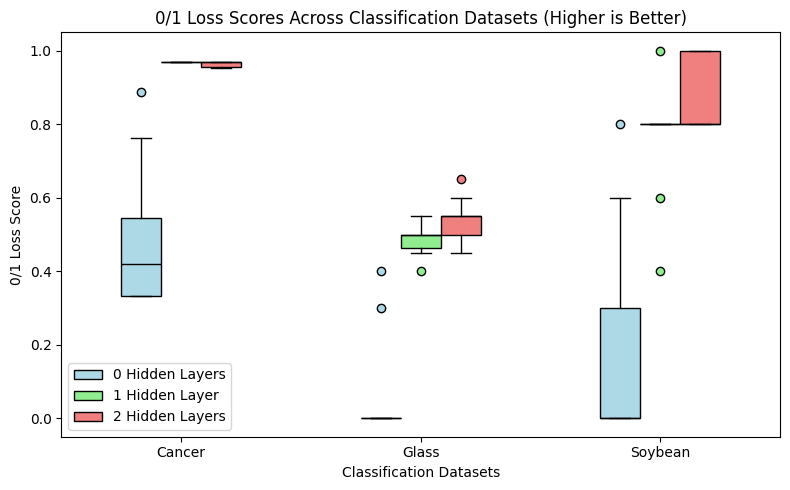

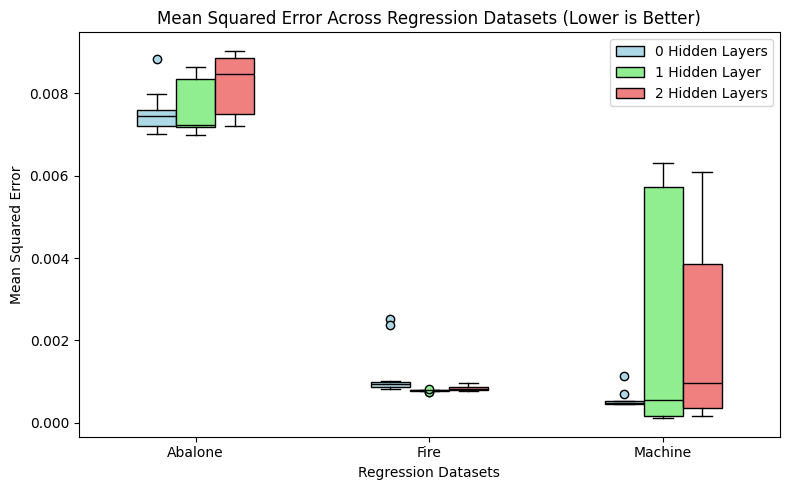

In [92]:
classification_arrays = [cancer_0_score,cancer_1_score,cancer_2_score,
                         glass_0_score,glass_1_score,glass_2_score,
                         soybean_0_score,soybean_1_score,soybean_2_score]
regression_arrays = [abalone_0_score,abalone_1_score,abalone_2_score,
                     fire_0_score,fire_1_score,fire_2_score,
                     machine_0_score,machine_1_score,machine_2_score]
arrays_to_save = []
arrays_to_save.extend(classification_arrays)
arrays_to_save.extend(regression_arrays)
#print(arrays_to_save)
save_arrays_to_csv(arrays_to_save, 'results.csv')
loaded_arrays = load_arrays_from_csv('results.csv')
classification_arrays = loaded_arrays[:9]
regression_arrays = loaded_arrays[9:]
#loaded_arrays = classification_arrays
#loaded_arrays.extend(regression_arrays)
classification_dataset_names = ['Cancer', 'Glass', 'Soybean']
regression_dataset_names = ['Abalone', 'Fire', 'Machine']

make_plots_2(loaded_arrays, classification_dataset_names, regression_dataset_names, (8, 5), 0, '/home/carlthedog3/CSCI_447/Project_3/Code/Figures/')